# Overview

In the notebook [Fixing the saturated tanh of training MLP](https://www.kaggle.com/code/aisuko/fixing-the-saturated-tanh-of-training-mlp/notebook), we fixed the initial with extreme large issue cause dead neuron of neural nets by setting the initial value of weights and bias to small number like `0.01` or `0`.

```python
g=torch.Generator().manual_seed(2147483647) # for reproducibility
C=torch.randn((vocab_size, n_embd),           generator=g)
W1=torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.2
b1=torch.randn(n_hidden,                      generator=g) * 0.01
W2=torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2=torch.randn(vocab_size,                    generator=g) * 0
```

However, we can't do this in practice(set these number by hands). **Here is the question, how to setting these scales in a principled way?**

tensor(-0.0081) tensor(1.0068)
tensor(0.0129) tensor(3.1721)


(array([6.85288179e-06, 1.37057636e-05, 2.74115272e-05, 3.42644090e-05,
        1.37057636e-05, 2.05586454e-05, 1.23351872e-04, 1.98733572e-04,
        3.15232563e-04, 5.55083425e-04, 9.79962097e-04, 1.42539941e-03,
        2.38480286e-03, 3.79649651e-03, 5.85921393e-03, 9.86129690e-03,
        1.45418152e-02, 2.24363350e-02, 3.20646339e-02, 4.62226877e-02,
        6.37455065e-02, 8.44754739e-02, 1.02567082e-01, 1.21138391e-01,
        1.33740841e-01, 1.33453020e-01, 1.27586953e-01, 1.14799476e-01,
        9.46314447e-02, 7.48540278e-02, 5.64403345e-02, 4.05279429e-02,
        2.79049347e-02, 1.94073612e-02, 1.27326544e-02, 7.93563712e-03,
        5.18077864e-03, 3.37161784e-03, 1.87083673e-03, 1.27463601e-03,
        8.42904461e-04, 5.07113253e-04, 2.39850863e-04, 1.91880690e-04,
        1.02793227e-04, 6.16759362e-05, 4.11172908e-05, 2.74115272e-05,
        6.85288179e-06, 3.42644090e-05]),
 array([-18.45133591, -17.72171585, -16.99209579, -16.26247574,
        -15.53285568, -14.8032

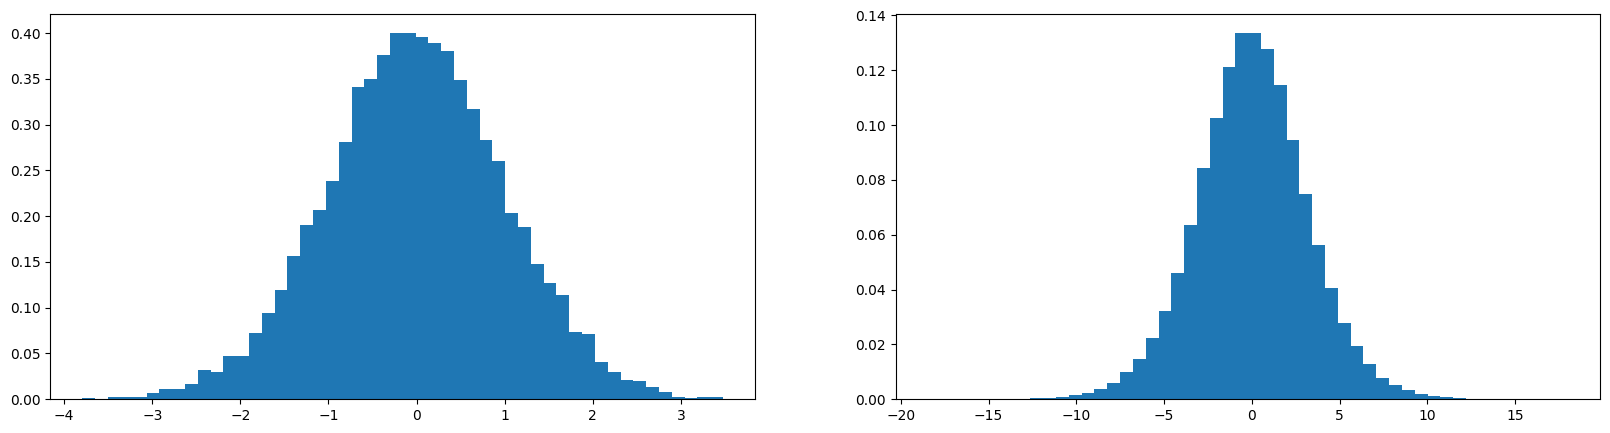

In [1]:
import torch
import matplotlib.pyplot as plt # for making figures


# input layer:
# initialize with gaussian
# 1000 example that are 10 dimensional
x=torch.randn(1000,10)

# weight/hidden layer:
# initialize with gaussian
# 10 inputs
# 200 neurons 
w=torch.randn(10, 200)

# here we get the pre-activations of these neurons by multiplying x and w
y=x@w
print(x.mean(), x.std())
print(y.mean(), y.std())

# preserve this distribution to remain a gaussian
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

# What's the mean and the standard deviation of these gaussians?

In our example, the input here is just a normal gaussian distrbution mean zero and the standard deviation is one and the standard deviation again is just a measure of a spread of discussion.

But then once we multiply `y=x@w`, the mean of course stays the same(it's abnout zero) because this is a symmetric operation, but the standard deviation has expanded to three.

```
tensor(0.0089) tensor(1.0014)
tensor(0.0087) tensor(3.1753)
```

So the input standard deviation was one but now we've grown to three. So the histogram is that this gaussian is expanding and so we're expanding this gaussian from the input. **And we don't want that. We want most of the neural nets to have relatively similar activations.** So unit gaussian roughly throughout the neural net.


# How do we scale these weights to preserve the distribution to remain a gaussian?

Let's see we multiply a big/small number seperately. The value of `y` is still not what we want.


tensor(-0.0063) tensor(0.9992)
tensor(-0.0042) tensor(15.8395)


(array([2.86694135e-06, 4.30041202e-06, 7.16735337e-06, 5.73388270e-06,
        1.57681774e-05, 2.58024721e-05, 2.72359428e-05, 6.59396510e-05,
        1.27578890e-04, 2.17887542e-04, 2.96728430e-04, 5.01714736e-04,
        8.25679108e-04, 1.23278478e-03, 1.84487676e-03, 2.95868347e-03,
        4.47959586e-03, 6.36460979e-03, 8.73270335e-03, 1.19021070e-02,
        1.54442130e-02, 1.92386099e-02, 2.27678147e-02, 2.57465668e-02,
        2.68689743e-02, 2.64159976e-02, 2.45037477e-02, 2.13286102e-02,
        1.76789938e-02, 1.36839111e-02, 1.03869285e-02, 7.48128345e-03,
        5.16766178e-03, 3.74995928e-03, 2.39819644e-03, 1.58255162e-03,
        1.02493153e-03, 6.36460979e-04, 3.72702375e-04, 2.25054896e-04,
        1.59115245e-04, 6.73731217e-05, 5.87722976e-05, 1.57681774e-05,
        2.72359428e-05, 7.16735337e-06, 5.73388270e-06, 5.73388270e-06,
        1.43347067e-06, 2.86694135e-06]),
 array([-86.36405945, -82.87602158, -79.3879837 , -75.89994583,
        -72.41190796, -68.9238

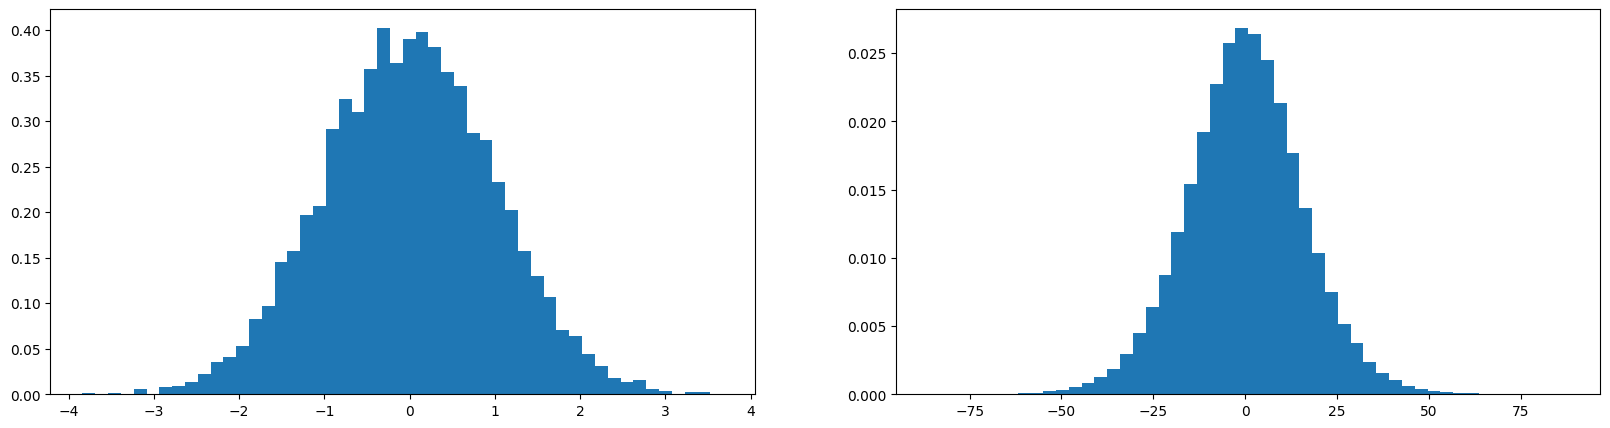

In [2]:
# input layer:
# initialize with gaussian
# 1000 example that are 10 dimensional
x=torch.randn(1000,10)

# weight/hidden layer:
# initialize with gaussian
# 10 inputs
# 200 neurons 
w=torch.randn(10, 200) * 5

# here we get the pre-activations of these neurons by multiplying x and w
y=x@w
print(x.mean(), x.std())
print(y.mean(), y.std())

# preserve this distribution to remain a gaussian
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

tensor(-0.0041) tensor(0.9920)
tensor(0.0003) tensor(0.6269)


(array([1.44238729e-04, 7.21193643e-05, 1.44238729e-04, 2.88477457e-04,
        2.52417775e-04, 7.57253326e-04, 1.18996951e-03, 1.47844697e-03,
        2.84871489e-03, 5.37289264e-03, 8.04130912e-03, 1.36666195e-02,
        1.94361687e-02, 3.26340124e-02, 5.10605100e-02, 7.68431827e-02,
        1.09621434e-01, 1.62268570e-01, 2.31322861e-01, 3.06435179e-01,
        4.01885158e-01, 5.00580508e-01, 5.94660219e-01, 6.48785802e-01,
        6.86864826e-01, 6.74063639e-01, 6.04504512e-01, 5.24163540e-01,
        4.33004663e-01, 3.26592541e-01, 2.42393184e-01, 1.76764562e-01,
        1.27362797e-01, 8.74086696e-02, 5.74791334e-02, 3.60957419e-02,
        2.47008823e-02, 1.60104989e-02, 9.80823355e-03, 5.91378788e-03,
        3.20931171e-03, 2.12752125e-03, 1.58662602e-03, 1.11785015e-03,
        4.32716186e-04, 2.52417775e-04, 1.44238729e-04, 7.21193643e-05,
        0.00000000e+00, 7.21193643e-05]),
 array([-3.41621494, -3.27755593, -3.13889691, -3.0002379 , -2.86157888,
        -2.72291987, 

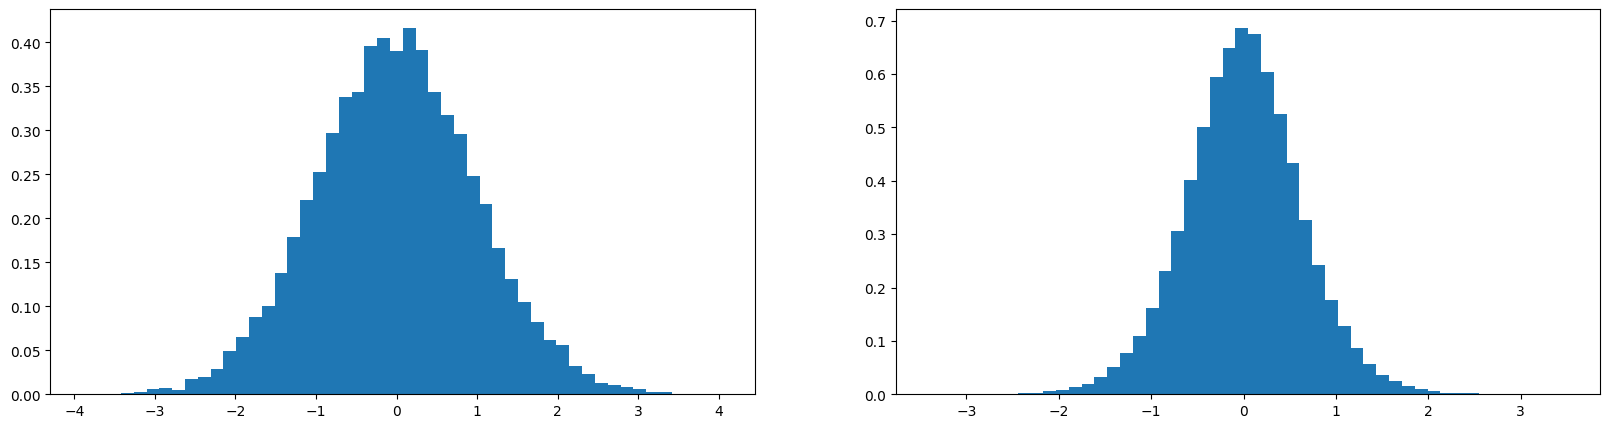

In [3]:
# input layer:
# initialize with gaussian
# 1000 example that are 10 dimensional
x=torch.randn(1000,10)

# weight/hidden layer:
# initialize with gaussian
# 10 inputs
# 200 neurons 
w=torch.randn(10, 200) * 0.2

# here we get the pre-activations of these neurons by multiplying x and w
y=x@w
print(x.mean(), x.std())
print(y.mean(), y.std())

# preserve this distribution to remain a gaussian
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

# What do I multiply by here to exactly preserve the standard deviation to be one?

It turns out that the correct answer mathematically when you work out through the variance of this multiplcation. Here is that you are supposed to divide by the square root of the fan in which is the number of input elements, here is 10.

tensor(-0.0104) tensor(0.9987)
tensor(-0.0024) tensor(1.0053)


(array([6.36838327e-05, 0.00000000e+00, 1.48595610e-04, 2.33507386e-04,
        1.48595610e-04, 5.51926550e-04, 9.76485434e-04, 1.54963993e-03,
        2.84454453e-03, 4.01208146e-03, 6.43206710e-03, 1.08262516e-02,
        1.70248113e-02, 2.67684377e-02, 4.17129104e-02, 6.20917369e-02,
        9.27448883e-02, 1.33077982e-01, 1.82687688e-01, 2.44949248e-01,
        3.10140265e-01, 3.76392679e-01, 4.17277700e-01, 4.35661099e-01,
        4.14921398e-01, 3.63528545e-01, 3.04238897e-01, 2.37031225e-01,
        1.76701408e-01, 1.26921879e-01, 8.89663143e-02, 5.77400083e-02,
        3.88683659e-02, 2.68108936e-02, 1.67913039e-02, 9.40397929e-03,
        5.92259644e-03, 4.20313296e-03, 1.93174292e-03, 1.18876488e-03,
        8.70345713e-04, 6.15610383e-04, 2.75963275e-04, 8.49117769e-05,
        8.49117769e-05, 0.00000000e+00, 4.24558885e-05, 4.24558885e-05,
        4.24558885e-05, 4.24558885e-05]),
 array([-5.52219629, -5.28665771, -5.05111912, -4.81558053, -4.58004194,
        -4.34450336, 

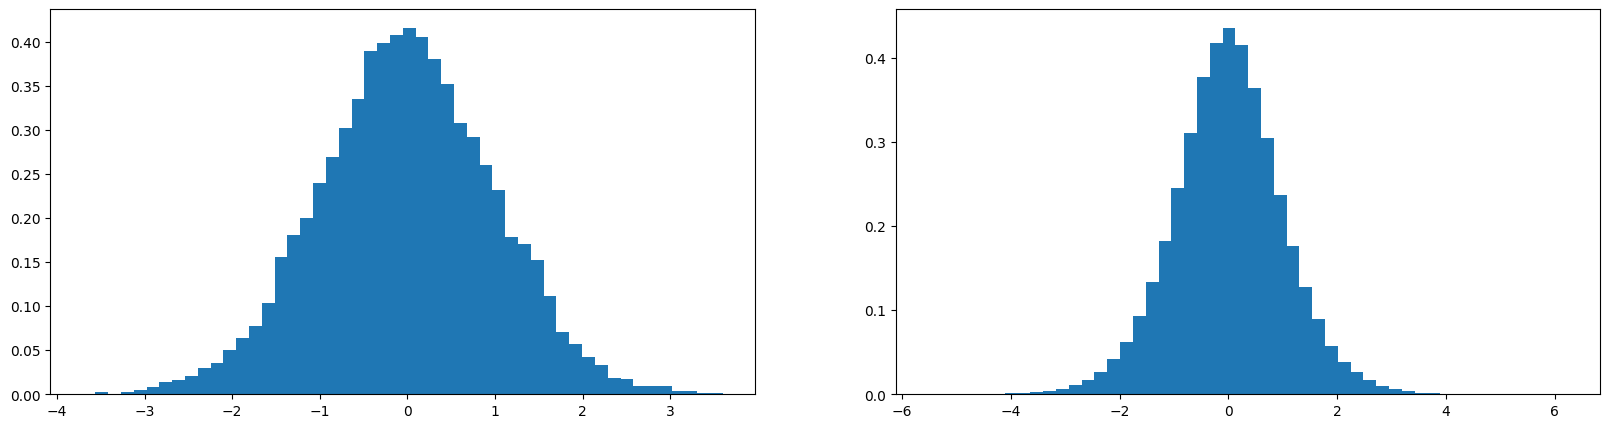

In [4]:
# input layer:
# initialize with gaussian
# 1000 example that are 10 dimensional
x=torch.randn(1000,10)

# weight/hidden layer:
# initialize with gaussian
# 10 inputs
# 200 neurons

# here we divide by 10 square root
w=torch.randn(10, 200) / 10**0.5

# here we get the pre-activations of these neurons by multiplying x and w
y=x@w
print(x.mean(), x.std())
print(y.mean(), y.std())

# preserve this distribution to remain a gaussian
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

# How to best initialize neural networks?

In the case of multiplayer perceptions we have fairly deep networks that have these nonlinearties inbetween and we want to make sure that the activations are well behaved and they don't expand to infinity or shrink all the way to zero.


# How do we initlize the weights?

We want to initilize the weights so that these activations take on reasonbale values threoughout the network.

Normally we can use [torch::nn::init::kaiming_normal_](https://pytorch.org/cppdocs/api/function_namespacetorch_1_1nn_1_1init_1ac8a913c051976a3f41f20df7d6126e57.html). We can get a gain of different activation funsions from [torch.nn.init](https://pytorch.org/docs/stable/nn.init.html).


# Why do we need a gain on top of the initialization?

Because `tanh` just like relu is a contractive transformation. So the output distribution from this matrix multiplication and then you are squashing it in some way. `Relu` squashes it by taking everything below zero and clamping it to zero, `tanh` also squashes it because it's a contractual operation. It will take the tails and it will squeeze them in and so in order to fight the squeezing in we need to boost the weights a little bit, so that we renormalize everything back to standard unit.


# Modern innovations have made everything significantly more stable

* Resisual connections
* Normalization layers
  * Batch normalization
  * Layer normalization
  * Group normalization
 * Much better optimizers
   * RMS prop
   * Adam
   
Although we have these innovations help us, we can also normalize our weights by the square root of the fan in when we initialize the neural nets.

In [5]:
# check the standard deviation of input tesnors
torch.randn(10000).std()

tensor(0.9958)

In [6]:
# scale down the gaussian by making its standard deviation 0.2
(torch.randn(10000)*0.2).std()

tensor(0.1982)

# Set the standard deviation to gain over square root of fan mode

For tanh is $5/3$, and square of fan in is `n_embd*block_size, n_hidden` =30

In [7]:
(5/3)/(30**0.5)

0.3042903097250923

So, we need to initialize our network below

```python
g=torch.Generator().manual_seed(2147483647) # for reproducibility
C=torch.randn((vocab_size, n_embd),           generator=g)
W1=torch.randn((n_embd*block_size, n_hidden), generator=g) * ((5/3)/((n_embd*block_size)**0.5))
b1=torch.randn(n_hidden,                      generator=g) * 0.01
W2=torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2=torch.randn(vocab_size,                    generator=g) * 0
```



# Acknowledgement

* https://www.youtube.com/watch?v=P6sfmUTpUmc&t=1679s

# Further reading

* https://pytorch.org/cppdocs/api/function_namespacetorch_1_1nn_1_1init_1ac8a913c051976a3f41f20df7d6126e57.html
* https://arxiv.org/abs/1502.01852